# Setup

- The Liesel documentation can be found here: https://docs.liesel-project.org/en/latest/
- Track the release of new versions and report bugs here: https://github.com/liesel-devs/liesel
- Please feel invited to ask questions here: https://github.com/liesel-devs/liesel/discussions

In [1]:
# This cell installs the necessary packages.
# Uncomment the lines below to install the packages when running
# the notebook on Google Colab.

# %%capture
# !apt install libgraphviz-dev # necessary here for successful pygraphviz installation
# %pip install pygraphviz # install pygraphviz (for plotting model graphs nicely)
# %pip install rpy2 # install rpy2 for interfacing R and Python
# %pip install liesel # install liesel
# %pip install plotnine # install plotnine for ggplot2-like plotting in Python


In [2]:
# This cell installs R, mgcv and BayesX for us
# Uncomment the lines below to install the packages when running
# the notebook on Google Colab.

# careful, the installation of BayesX takes a long time!

# the command '%%capture' prevents ouput from being continuously printed
# this is nice here, because the output is very long

# %%capture
# !apt-get install -y r-base
# !Rscript -e "install.packages('mgcv', repos='http://cran.rstudio.com/')"
# !Rscript -e "install.packages('BayesX', repos='http://cran.rstudio.com/')"

In [3]:
%load_ext rpy2.ipython

In [4]:
import numpy as np # for numerical operations
import jax.numpy as jnp # for jit-compilable numerical operations
import tensorflow_probability.substrates.jax.distributions as tfd # for probability distributions


import liesel.model as lsl # Liesel's model-building module
import liesel.goose as gs # Liesel's MCMC module
from liesel.distributions import MultivariateNormalDegenerate as MVND # for the rank-deficient multivariate normal distribution

import plotnine as p9 # for ggplot2-like plotting

In [5]:
# for interfacing R and Python
from rpy2 import robjects

robjects.pandas2ri.activate()

## Data Import

In [6]:
%%R
library(mgcv)
library(MASS)
data(mcycle)

Lade nötiges Paket: nlme
This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


In [9]:
# pass the zambia data frame to Python
# we explicitly convert the data frame to a pandas data frame
mcycle = robjects.globalenv['mcycle']

In [10]:
mcycle.head()

,times,accel
1,2.4,0.0
2,2.6,-1.3
3,3.2,-2.7
4,3.6,0.0
5,4.0,-2.7


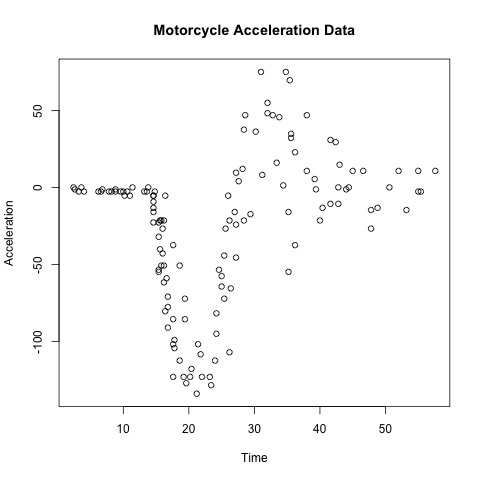

In [67]:
%%R
plot(mcycle$time, mcycle$accel, xlab = "Time", ylab = "Acceleration", main = "Motorcycle Acceleration Data")

# Model 1: Location-Model

In [68]:
%%R
# set up basis matrix and penalty matrix in magcv

s_times <- mgcv::smoothCon(
    s(times, bs="ps", m=c(3,2), k=20),
    data = mcycle,
    knots = NULL,
    absorb.cons = TRUE
)

# basis_times_r <- s_times[[1]]$X
# pen_times_r <- s_times[[1]]$S[[1]]

# optional diagonalization of the penalty matrix
s_times <- s_times[[1]] |> mgcv::smooth2random(vnames = "", type = 2)

basis_times_r <- cbind(s_times$rand$Xr, s_times$Xf)
pen_times_r <- diag(s_times$pen.ind)

In [69]:
# get R objects into python
basis_times_r = robjects.globalenv['basis_times_r']
pen_times_r = robjects.globalenv['pen_times_r']

In [70]:
# set up structured additive term in liesel
basis_times = lsl.Var.new_obs(basis_times_r, name="basis_times")

mvnd = MVND.from_penalty(loc=0.0, var=1.0, pen=pen_times_r)

# set up tau2 prior and variable
# tau2_times_loc_prior = lsl.Dist(tfd.InverseGamma, concentration=0.01, scale=0.01)
# tau2_times_loc = lsl.Var.new_param(10.0, tau2_times_loc_prior, name="tau2_times_loc")
# var_param_times_loc = tau2_times_loc

# A diffuse prior with nonzero density at zero
# The scale can be set according to the principles of a scale-dependent prior
# See Klein & Kneib (2016) for details
tau_times_loc_prior = lsl.Dist(tfd.Weibull, concentration=0.5, scale=20.0)
tau_times_loc = lsl.Var.new_param(10.0, tau_times_loc_prior, name="tau_times_loc")
tau2_times_loc = lsl.Var.new_calc(jnp.square, tau_times_loc, name="tau2_times_loc")
var_param_times_loc = tau_times_loc

# set up coefficient prior
coef_times_loc_prior = lsl.Dist(
    MVND.from_penalty,
    loc=0.0,
    var=tau2_times_loc,
    pen=pen_times_r,
    rank=mvnd.rank,
    log_pdet=mvnd.log_pdet
)

# set up coefficient variable
coef_times_loc = lsl.Var.new_param(
    value=jnp.zeros(basis_times_r.shape[1]),
    distribution=coef_times_loc_prior,
    name="coef_times_loc"
)

# set up effect variable
s_times_loc = lsl.Var.new_calc(jnp.dot, basis_times, coef_times_loc, name="s_times_loc")

In [71]:
intercept_loc = lsl.Var.new_param(
    mcycle["accel"].mean(), # crude starting value
    name="intercept_loc"
)

loc = lsl.Var.new_calc(lambda *args: sum(args), intercept_loc, s_times_loc, name="loc")

variance = lsl.Var.new_param(
    mcycle["accel"].var(), # crude starting value
    lsl.Dist(tfd.InverseGamma, concentration=0.01, scale=0.01), 
    name="variance"
)

scale = lsl.Var.new_calc(jnp.sqrt, variance, name="scale")

accel_dist = lsl.Dist(tfd.Normal, loc=loc, scale=scale)
accel = lsl.Var.new_obs(mcycle["accel"].values, distribution=accel_dist, name="accel")

liesel.model.model - INFO - Converted dtype of Value(name="accel_value").value
liesel.model.model - INFO - Converted dtype of Value(name="variance_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="basis_times_value").value
liesel.model.model - INFO - Converted dtype of Value(name="intercept_loc_value").value
liesel.model.nodes - INFO - Unnamed nodes were temporarily named for plottingThe automatically assigned names are: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7']. The names are reset after plotting.


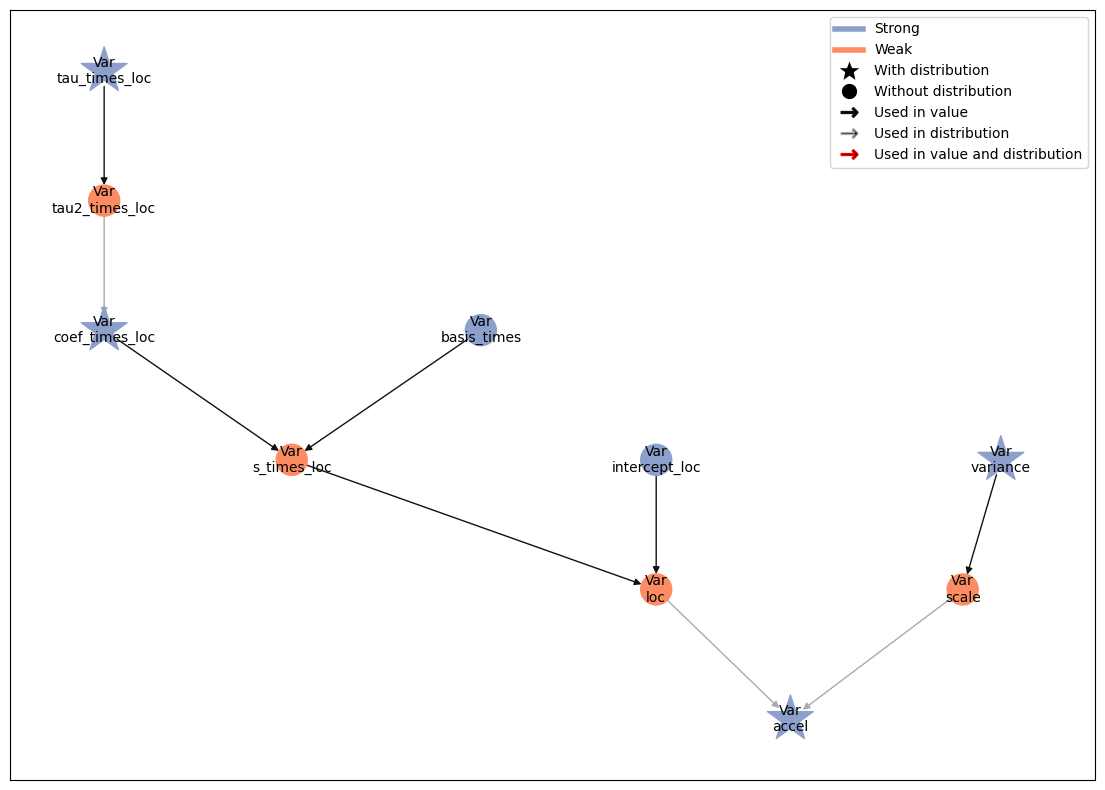

In [72]:
accel.plot_vars()

In [73]:
model1 = lsl.Model([accel])
interface = gs.LieselInterface(model1)

In [74]:
import optax

# crude, but robust optimization
preopt = gs.optim_flat(
    model_train=model1,
    params=[intercept_loc.name, coef_times_loc.name],
    stopper=gs.Stopper(max_iter=10_000, patience=10, atol=1e-3),
    optimizer=optax.adam(learning_rate=0.01)
)

Training loss: 776.791, Validation loss: 776.791:   0%|          | 11/10000 [00:00<21:11,  7.86it/s]  

Training loss: 732.852, Validation loss: 732.852:  27%|██▋       | 2713/10000 [00:10<00:27, 268.97it/s]

In [75]:
eb = gs.EngineBuilder(seed=42, num_chains=4)

eb.set_model(interface)
eb.set_initial_values(preopt.model_state)

eb.add_kernel(gs.NUTSKernel([intercept_loc.name]))

eb.add_kernel(gs.IWLSKernel([coef_times_loc.name]))
eb.add_kernel(gs.NUTSKernel([var_param_times_loc.name]))
eb.add_kernel(gs.NUTSKernel([variance.name]))

eb.positions_included = [s_times_loc.name, "_model_log_prob", "accel_log_prob"]

eb.set_duration(warmup_duration=2000, posterior_duration=2000)

In [76]:
engine = eb.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done


In [77]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
100%|██████████████████████████████████████████| 3/3 [00:05<00:00,  1.82s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 2, 0, 1 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 4, 7, 5, 5 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 4, 3, 7, 3 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 591.83chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 1, 1, 1 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 3, 1, 2, 3 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 1, 0, 1, 1 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
lies

In [78]:
results1 = engine.get_results()
samples1 = results1.get_posterior_samples()
summary1 = gs.Summary(results1, deselected=eb.positions_included)

In [79]:
summary1

Parameter summary:

                         kernel        mean         sd      q_0.05  \
parameter      index                                                 
coef_times_loc (0,)   kernel_01    0.771026  15.694371  -24.357420   
               (1,)   kernel_01   -5.113884  15.261616  -30.671770   
               (2,)   kernel_01   -0.483971  14.834035  -24.475492   
               (3,)   kernel_01    1.579086  14.342343  -22.522465   
               (4,)   kernel_01    6.950373  13.877000  -15.032477   
               (5,)   kernel_01    3.988844  12.929850  -17.116751   
               (6,)   kernel_01   -1.487482  11.945919  -20.847532   
               (7,)   kernel_01    4.010139  10.850174  -13.269432   
               (8,)   kernel_01  -13.747186  10.517638  -31.234554   
               (9,)   kernel_01  -24.585503  10.440127  -41.644706   
               (10,)  kernel_01    5.437226   9.666337  -10.644304   
               (11,)  kernel_01   26.514381   8.882793   12.096542   
               (12,)  kernel_01  -12.623721   7.885421  -25.543756   
               (13,)  kernel_01    9.819197   6.748928   -1.544183   
               (14,)  kernel_01   12.311284   5.185497    3.917424   
               (15,)  kernel_01    1.794927   3.576983   -3.966087   
               (16,)  kernel_01   -2.841736   1.994438   -6.091721   
               (17,)  kernel_01   -0.973379   0.828300   -2.358057   
               (18,)  kernel_01  -56.212677  56.198833 -150.230847   
intercept_loc  ()     kernel_00  -25.523891   1.989806  -28.790386   
tau_times_loc  ()     kernel_02   15.553860   3.763491   10.514264   
variance       ()     kernel_03  522.640869  68.794861  418.673892   

                           q_0.5      q_0.95  sample_size     ess_bulk  \
parameter      index                                                     
coef_times_loc (0,)     0.379888   26.482438         8000   562.955601   
               (1,)    -5.067636   19.739365         8000   453.759928   
               (2,)    -0.898824   24.263437         8000   650.442285   
               (3,)     1.672299   24.741682         8000   568.341756   
               (4,)     6.436541   30.573876         8000   586.887757   
               (5,)     3.946929   25.642764         8000   509.738176   
               (6,)    -1.575884   18.634786         8000   520.467439   
               (7,)     3.812489   22.359898         8000   739.061040   
               (8,)   -13.754148    3.390438         8000   618.931785   
               (9,)   -24.383985   -7.745760         8000   527.212746   
               (10,)    5.282222   21.283685         8000   565.599105   
               (11,)   26.369783   41.393534         8000   689.679576   
               (12,)  -12.755208    0.793136         8000   574.281614   
               (13,)    9.911710   20.686265         8000   670.503108   
               (14,)   12.207942   21.129396         8000   595.537740   
               (15,)    1.721918    7.739058         8000   697.588063   
               (16,)   -2.861523    0.492129         8000   653.275684   
               (17,)   -0.959959    0.374021         8000   672.522194   
               (18,)  -55.545805   35.848365         8000   657.292546   
intercept_loc  ()     -25.523450  -22.253664         8000  2586.637812   
tau_times_loc  ()      15.010548   22.333463         8000   521.365208   
variance       ()     517.503113  643.021277         8000  1788.871443   

                         ess_tail      rhat  
parameter      index                         
coef_times_loc (0,)    663.156255  1.007246  
               (1,)    975.841175  1.011084  
               (2,)    989.628690  1.003334  
               (3,)   1076.146125  1.002962  
               (4,)    944.243094  1.005752  
               (5,)   1084.899175  1.012594  
               (6,)    912.749324  1.007009  
               (7,)   1271.149250  1.003097  
               (8,)   1148.925631  1.006377  
               (

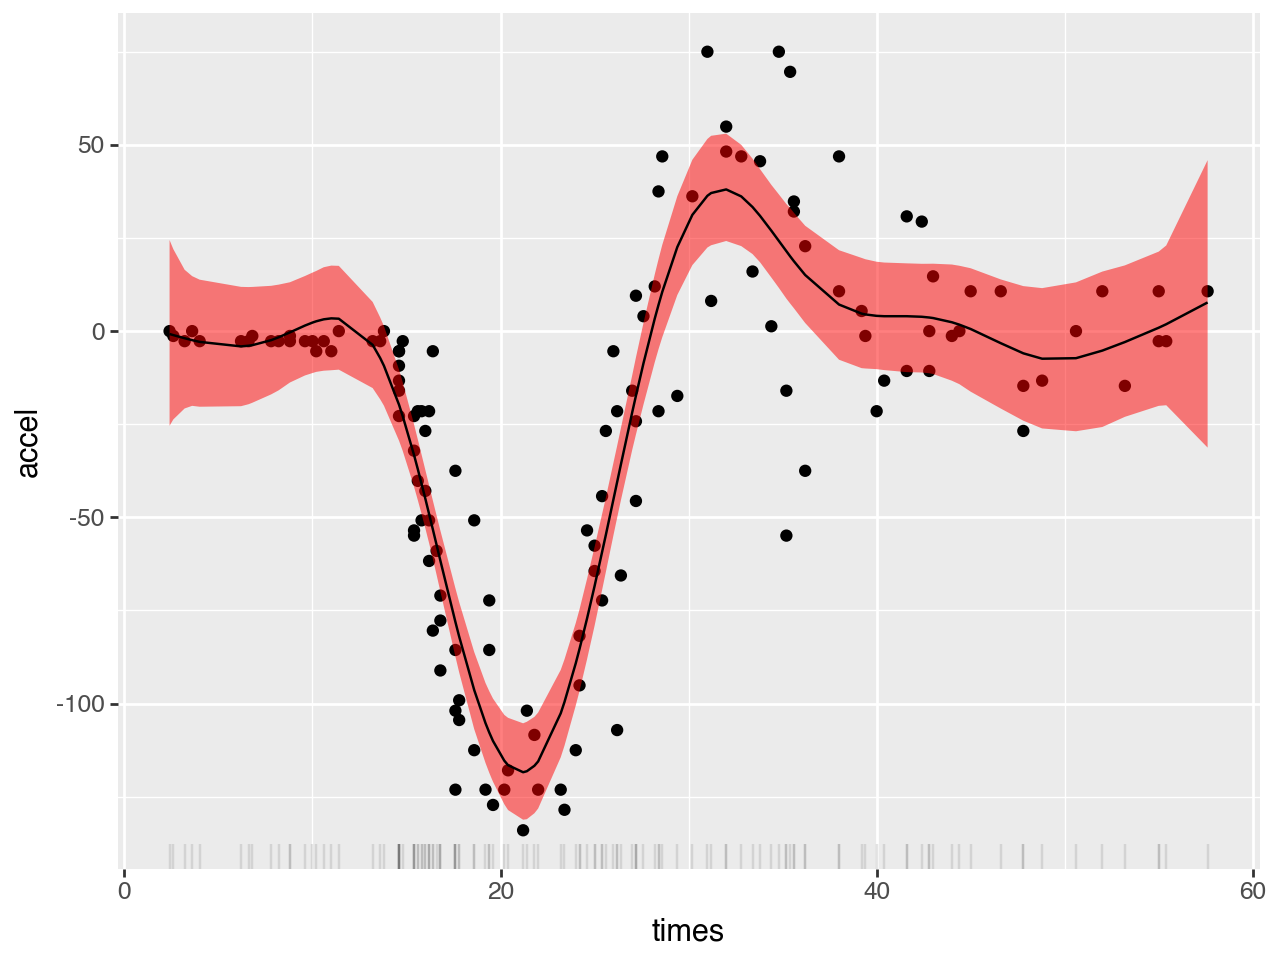

In [80]:
times_loc_samples = np.asarray(samples1[s_times_loc.name]) # convert to numpy array for plotting

times_loc_samples = times_loc_samples + samples1[intercept_loc.name][..., None] # include intercept for plotting

s_times_loc_mean = np.mean(times_loc_samples, axis=(0, 1))
s_times_loc_lo = np.quantile(times_loc_samples, 0.025, axis=(0, 1))
s_times_loc_hi = np.quantile(times_loc_samples, 0.975, axis=(0, 1))

(
    p9.ggplot()
    + p9.geom_point(p9.aes(x=mcycle["times"], y=mcycle["accel"]))
    + p9.geom_ribbon(p9.aes(x=mcycle["times"], ymin=s_times_loc_lo, ymax=s_times_loc_hi), alpha=0.5, fill = "red")
    + p9.geom_line(p9.aes(x=mcycle["times"], y=s_times_loc_mean))
    + p9.geom_rug(p9.aes(x=mcycle["times"]), alpha = 0.1)
)

# Model 2: Location-Scale Model

In [84]:
_ = model1.pop_nodes_and_vars()

In [85]:
# set up tau2 prior and variable
# tau2_times_scale_prior = lsl.Dist(tfd.InverseGamma, concentration=0.01, scale=0.01)
# tau2_times_scale = lsl.Var.new_param(10.0, tau2_times_scale_prior, name="tau2_times_scale")
# var_param_times_scale = tau2_times_scale

# A diffuse prior with nonzero density at zero
# The scale can be set according to the principles of a scale-dependent prior
# See Klein & Kneib (2016) for details
tau_times_scale_prior = lsl.Dist(tfd.Weibull, concentration=0.5, scale=20.0)
tau_times_scale = lsl.Var.new_param(10.0, tau_times_scale_prior, name="tau_times_scale")
tau2_times_scale = lsl.Var.new_calc(jnp.square, tau_times_scale, name="tau2_times_scale")
var_param_times_scale = tau_times_scale

# set up coefficient prior
coef_times_scale_prior = lsl.Dist(
    MVND.from_penalty,
    loc=0.0,
    var=tau2_times_scale,
    pen=pen_times_r, # taken from above
    rank=mvnd.rank, # taken from above
    log_pdet=mvnd.log_pdet # taken from above
)

# set up coefficient variable
coef_times_scale = lsl.Var.new_param(
    value=jnp.zeros(basis_times_r.shape[1]),
    distribution=coef_times_scale_prior,
    name="coef_times_scale"
)

# set up effect variable
# we use the same basis here
s_times_scale = lsl.Var.new_calc(jnp.dot, basis_times, coef_times_scale, name="s_times_scale")

In [86]:
intercept_loc = lsl.Var.new_param(
    mcycle["accel"].mean(), # crude starting value
    name="intercept_loc"
)

loc = lsl.Var.new_calc(lambda *args: sum(args), intercept_loc, s_times_loc, name="loc")

intercept_scale = lsl.Var.new_param(
    jnp.log(mcycle["accel"].std()), # crude starting value
    name="intercept_scale"
)

log_scale = lsl.Var.new_calc(lambda *args: sum(args), intercept_scale, s_times_scale, name="log_scale")
scale = lsl.Var.new_calc(jnp.exp, log_scale, name="scale")

accel_dist = lsl.Dist(tfd.Normal, loc=loc, scale=scale)
accel = lsl.Var.new_obs(mcycle["accel"].values, distribution=accel_dist, name="accel")

liesel.model.model - INFO - Converted dtype of Value(name="accel_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="intercept_loc_value").value
liesel.model.nodes - INFO - Unnamed nodes were temporarily named for plottingThe automatically assigned names are: ['n0', 'n1', 'n8', 'n9', 'n10', 'n11']. The names are reset after plotting.


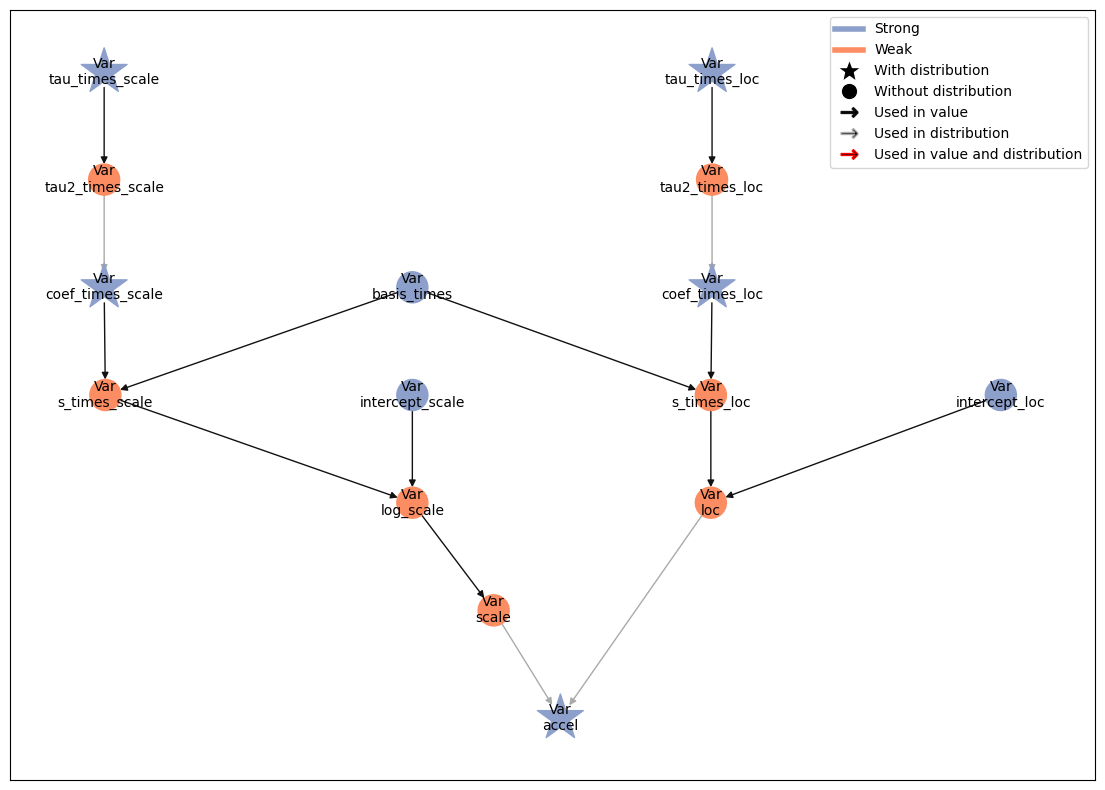

In [87]:
accel.plot_vars()

In [88]:
model2 = lsl.Model([accel])
interface = gs.LieselInterface(model2)

In [89]:
import optax

# crude, but robust optimization
preopt = gs.optim_flat(
    model_train=model2,
    params=[intercept_loc.name, coef_times_loc.name, intercept_scale.name, coef_times_scale.name],
    stopper=gs.Stopper(max_iter=10_000, patience=10, atol=1e-3),
    optimizer=optax.adam(learning_rate=0.01)
)

Training loss: 665.176, Validation loss: 665.176:  33%|███▎      | 3289/10000 [00:17<00:34, 192.57it/s]

Training loss: 665.176, Validation loss: 665.176:  33%|███▎      | 3289/10000 [00:31<00:34, 192.57it/s]

In [96]:
eb = gs.EngineBuilder(seed=42, num_chains=4)

eb.set_model(interface)
eb.set_initial_values(preopt.model_state)

eb.add_kernel(gs.NUTSKernel([intercept_loc.name, intercept_scale.name]))

eb.add_kernel(gs.IWLSKernel([coef_times_loc.name]))
eb.add_kernel(gs.NUTSKernel([var_param_times_loc.name]))

eb.add_kernel(gs.IWLSKernel([coef_times_scale.name]))
eb.add_kernel(gs.NUTSKernel([var_param_times_scale.name]))

eb.positions_included = [s_times_loc.name, s_times_scale.name, "_model_log_prob", "accel_log_prob"]

eb.set_duration(warmup_duration=2000, posterior_duration=2000)

In [97]:
engine = eb.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done


In [98]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together


100%|██████████████████████████████████████████| 3/3 [00:07<00:00,  2.65s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 2, 2, 3 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 3, 4, 2, 4 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 9, 7, 7, 7 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 492.81chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 1, 1, 3 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 1, 2, 2, 2 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 0, 0, 1, 1 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 3, 3, 2, 1 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.go

In [99]:
results2 = engine.get_results()
samples2 = results2.get_posterior_samples()
summary2 = gs.Summary(results2, deselected=eb.positions_included)

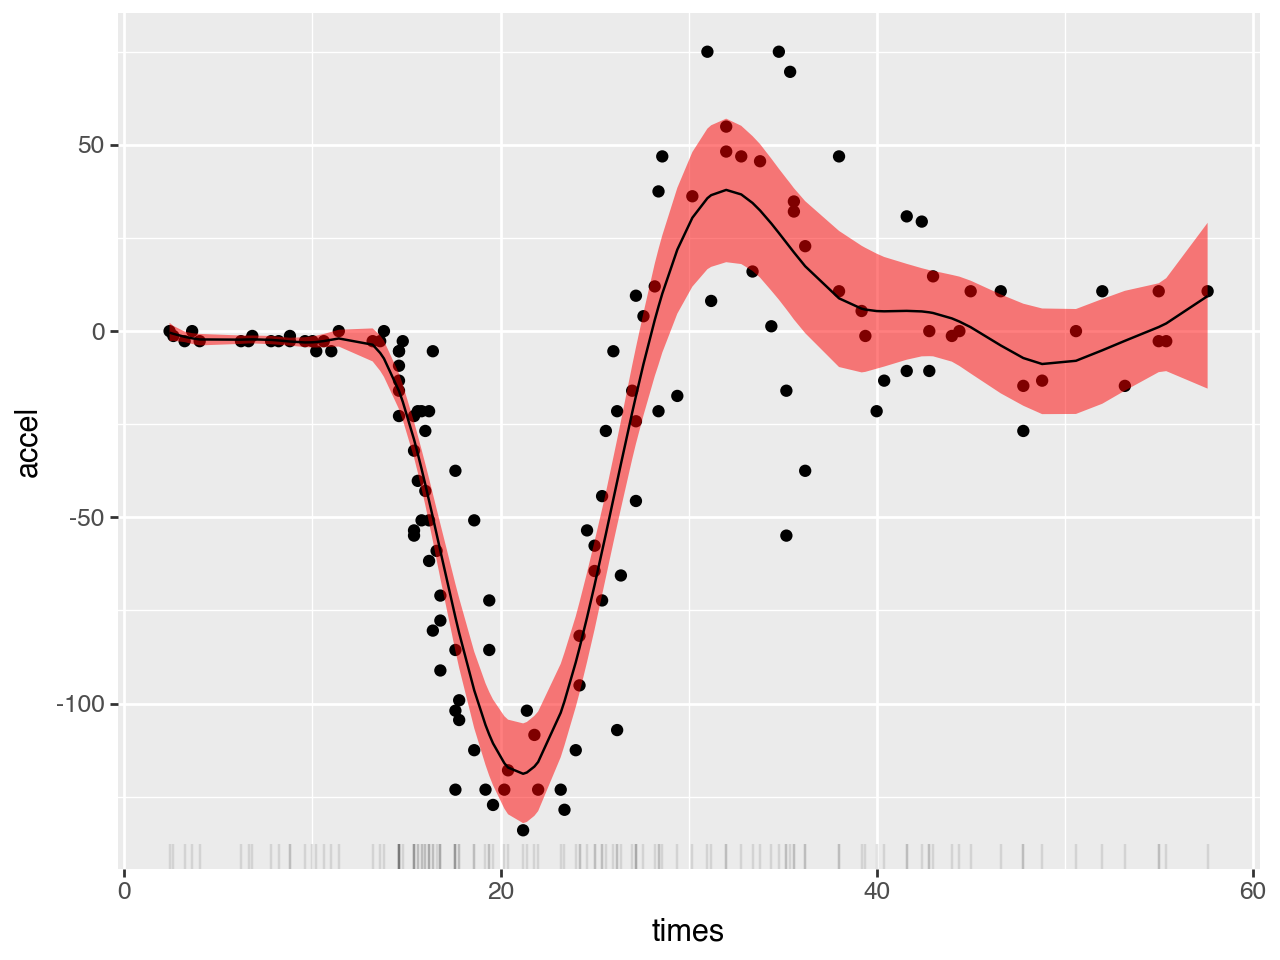

In [101]:
times_loc_samples = np.asarray(samples2[s_times_loc.name]) # convert to numpy array for plotting

times_loc_samples = times_loc_samples + samples2[intercept_loc.name][..., None] # include intercept for plotting

s_times_loc_mean = np.mean(times_loc_samples, axis=(0, 1))
s_times_loc_lo = np.quantile(times_loc_samples, 0.025, axis=(0, 1))
s_times_loc_hi = np.quantile(times_loc_samples, 0.975, axis=(0, 1))

(
    p9.ggplot()
    + p9.geom_point(p9.aes(x=mcycle["times"], y=mcycle["accel"]))
    + p9.geom_ribbon(p9.aes(x=mcycle["times"], ymin=s_times_loc_lo, ymax=s_times_loc_hi), alpha=0.5, fill = "red")
    + p9.geom_line(p9.aes(x=mcycle["times"], y=s_times_loc_mean))
    + p9.geom_rug(p9.aes(x=mcycle["times"]), alpha = 0.1)
)

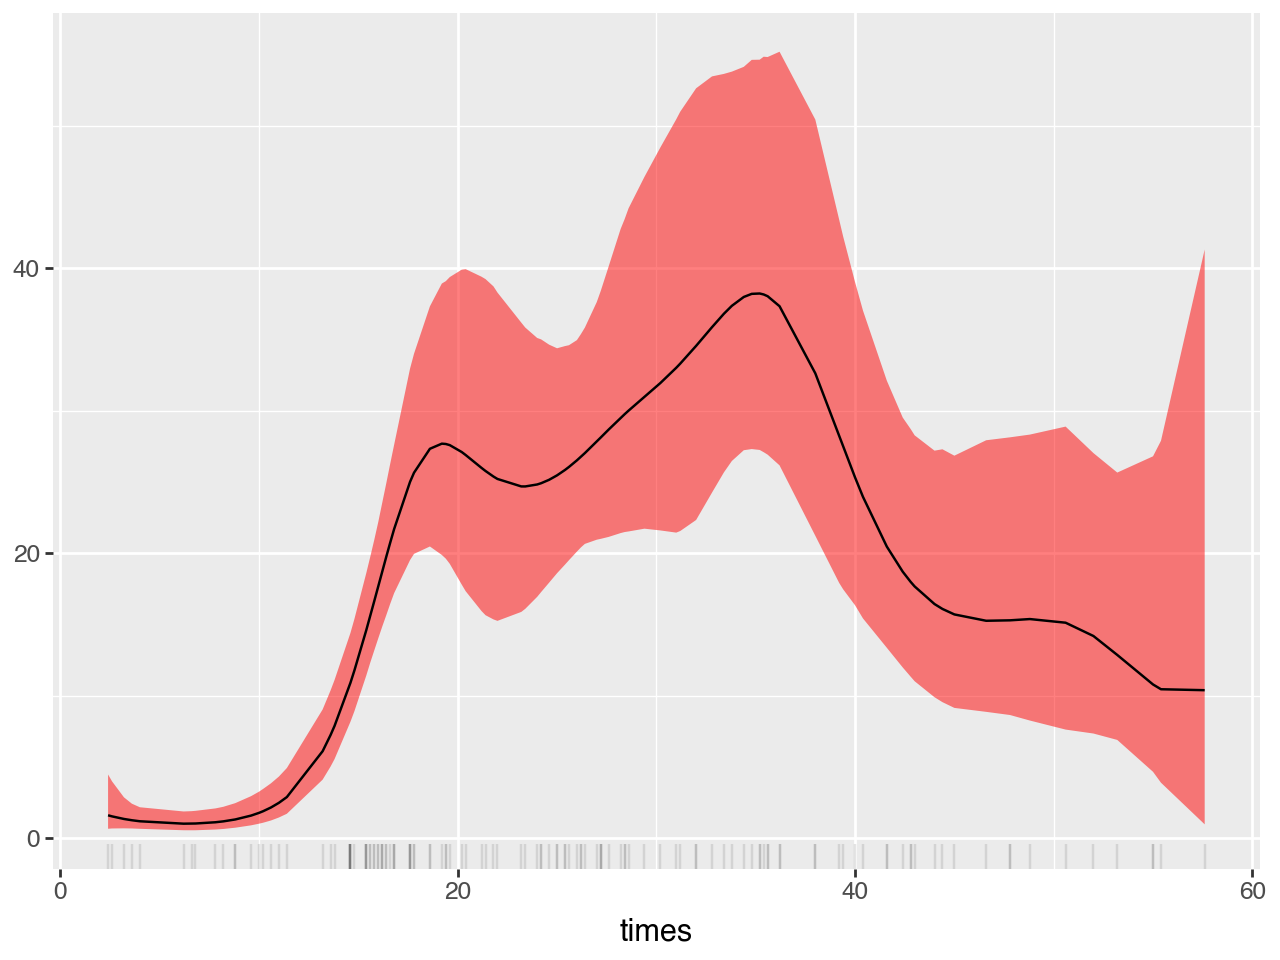

In [104]:
times_scale_samples = np.asarray(samples2[s_times_scale.name]) # convert to numpy array for plotting

times_scale_samples = jnp.exp(times_scale_samples + samples2[intercept_scale.name][..., None]) # include intercept for plotting

s_times_scale_mean = np.mean(times_scale_samples, axis=(0, 1))
s_times_scale_lo = np.quantile(times_scale_samples, 0.025, axis=(0, 1))
s_times_scale_hi = np.quantile(times_scale_samples, 0.975, axis=(0, 1))

(
    p9.ggplot()
    + p9.geom_ribbon(p9.aes(x=mcycle["times"], ymin=s_times_scale_lo, ymax=s_times_scale_hi), alpha=0.5, fill = "red")
    + p9.geom_line(p9.aes(x=mcycle["times"], y=s_times_scale_mean))
    + p9.geom_rug(p9.aes(x=mcycle["times"]), alpha = 0.1)
)

In [ ]:
s_times_scale_mean

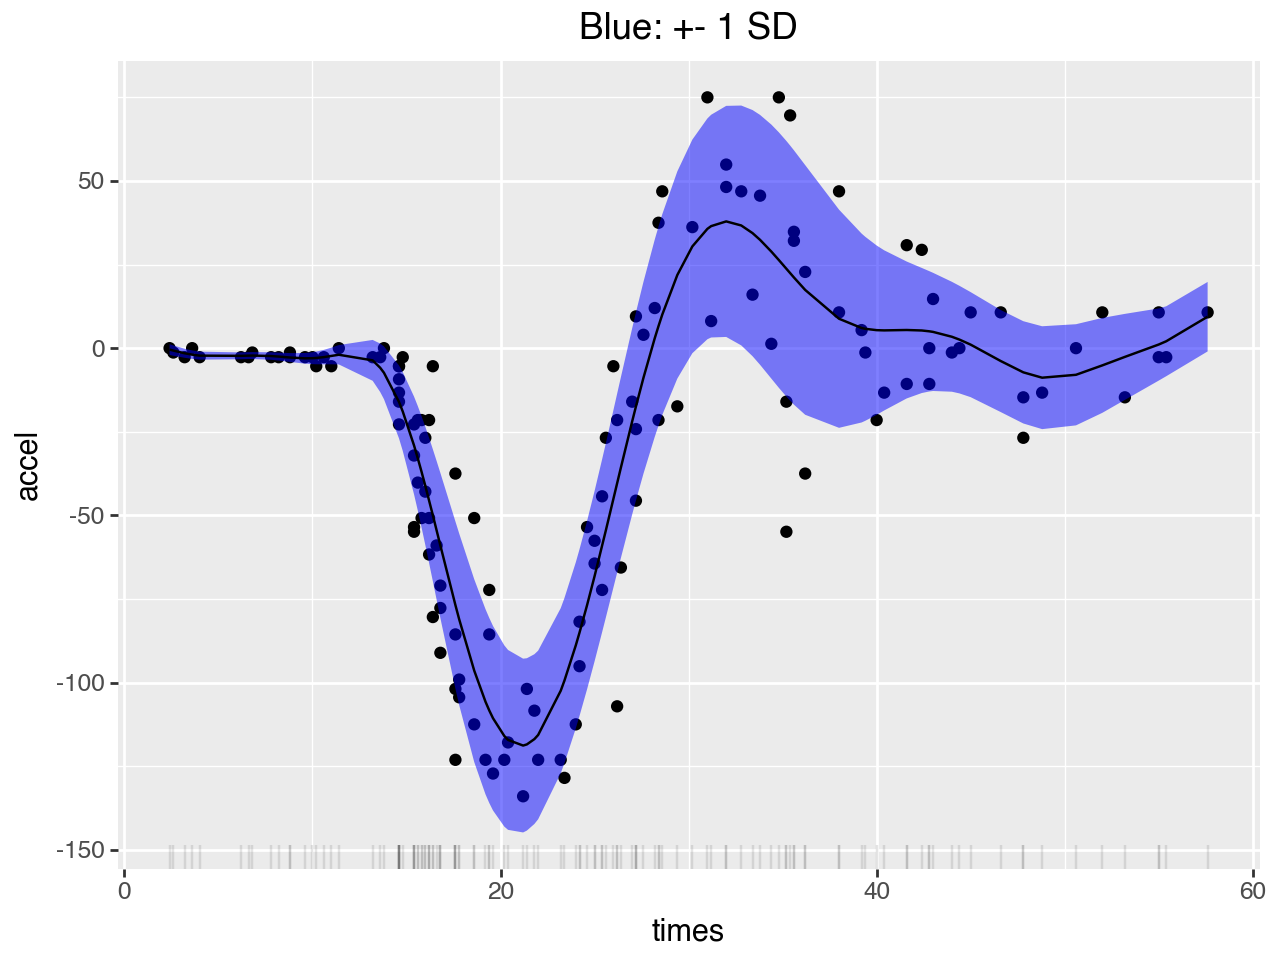

In [107]:
times_loc_samples = np.asarray(samples2[s_times_loc.name]) # convert to numpy array for plotting

times_loc_samples = times_loc_samples + samples2[intercept_loc.name][..., None] # include intercept for plotting

s_times_loc_mean = np.mean(times_loc_samples, axis=(0, 1))
s_times_loc_lo = s_times_loc_mean - s_times_scale_mean
s_times_loc_hi = s_times_loc_mean + s_times_scale_mean

(
    p9.ggplot()
    + p9.geom_point(p9.aes(x=mcycle["times"], y=mcycle["accel"]))
    + p9.geom_ribbon(p9.aes(x=mcycle["times"], ymin=s_times_loc_lo, ymax=s_times_loc_hi), alpha=0.5, fill = "blue")
    + p9.geom_line(p9.aes(x=mcycle["times"], y=s_times_loc_mean))
    + p9.geom_rug(p9.aes(x=mcycle["times"]), alpha = 0.1)
    + p9.labs(title="Blue: +- 1 SD")
)

# WAIC Computation

In [108]:
import arviz as az
from liesel.experimental.arviz import to_arviz_inference_data

In [125]:
# re-interpret the data
idat = to_arviz_inference_data(results1)

llpw_extracted = idat.posterior['accel_log_prob']
idat.posterior = idat.posterior.drop_vars('accel_log_prob')
idat.add_groups({'log_likelihood': {'observed': llpw_extracted}})

waic = az.waic(idat)
-2 * waic.elpd_waic # bring to deviance scale

/Users/johannesbrachem/.pyenv/versions/3.12.2/envs/liesel-3.12/lib/python3.12/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details


1219.9479052750394

In [126]:
# re-interpret the data
idat = to_arviz_inference_data(results2)

llpw_extracted = idat.posterior['accel_log_prob']
idat.posterior = idat.posterior.drop_vars('accel_log_prob')
idat.add_groups({'log_likelihood': {'observed': llpw_extracted}})

waic = az.waic(idat)
-2 * waic.elpd_waic # bring to deviance scale

/Users/johannesbrachem/.pyenv/versions/3.12.2/envs/liesel-3.12/lib/python3.12/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details


1112.2402078062296